In [70]:
from pymongo import MongoClient
import matplotlib.pyplot as plt
import numpy as np

client = MongoClient()
peoplecount = client['bigdata']['peoplecount']

In [71]:
c = peoplecount.aggregate([
    {
        '$group': {
            '_id': {
                '$dateToString': {
                    'date': '$day',
                    'format': '%Y-%U'
                }
            },
            'count': {
                '$sum': '$count'
            }
        }
    },
    {
        '$sort': {
            '_id': 1
        }
    }
])
aggregate = list(c)

In [72]:
lasts = [x for x in aggregate if x['_id'].endswith('52')]
firsts = [x for x in aggregate if x['_id'].endswith('00')]

In [73]:
for i in range(2):
    lasts[i]['count'] += firsts[i]['count']
aggregate = [x for x in aggregate if not x['_id'].endswith('00')]

In [74]:
first_part = [x for x in aggregate if '2018-44' <= x['_id'] <= '2019-43']
second_part = [x for x in aggregate if '2019-44' <= x['_id'] <= '2020-43']

#first_part = [x for x in aggregate if '2018-11' <= x['_id'] <= '2019-10']
#second_part = [x for x in aggregate if '2019-11' <= x['_id'] <= '2020-10']

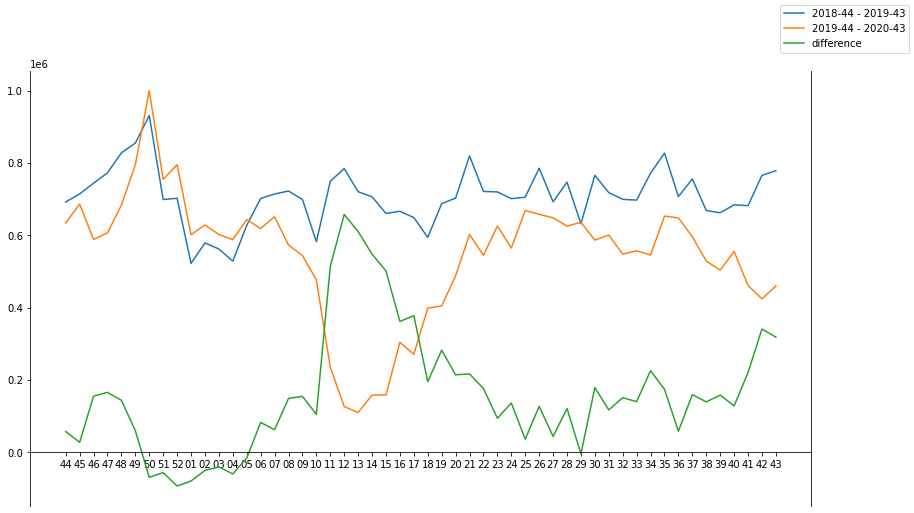

In [78]:
f, ax = plt.subplots(figsize=(14,8))

xs = [x['_id'][5:] for x in first_part]
y1s = [y['count'] for y in first_part]
y2s = [y['count'] for y in second_part]
ax.plot(xs, y1s, label = first_part[0]['_id'] + ' - ' + first_part[-1]['_id'])
ax.plot(xs, y2s, label = second_part[0]['_id'] + ' - ' + second_part[-1]['_id'])
ax.plot(xs, np.array(y1s) - np.array(y2s), label = 'difference')

f.legend()
#ax.set_ylim(ymin=0)
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
plt.show()